# Harpsichord Sound Synthesis

The Karplus-Strong plucked string instrument synthesis algorithm was originally published in 1984. This algorithm belongs to a family of synthesis algorithms known as *waveguide synthesis*.

The classic Karplus-Strong algorithm starts with an excitation signal that consists of randomly-generated 1s and -1s (effectively, a wavetable containing noise). Then, the envelope of the waveform is determined by averaging the previous two samples at each sample. As written in the paper:

$$Y_t = \frac{1}{2}(Y_{t-p} + Y_{t-p-1})$$

Where $Y_t$ is the level at sample $t$.  

This effectively simulates decay by gradually forcing the samples towards 0 (this can be guaranteed by randomly distributing 1s and -1s in the excitation signal). Periodicity is introduced by looping back through the excitation signal while generating the plucked string audio. Therefore, the tone produced can be controlled by changing the length of the excitation signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from IPython.display import Audio
from numpy.fft import fft, ifft
%matplotlib inline

fs = 44100

In [ ]:
def karplus_strong(wavtab, n_samples):
	samples = []
	t = 0

	# there is probably a closed form for this equation
	# this is effectively a delay line of length equal to len(wavtab)
	while len(samples) < n_samples:
		previous_value = wavtab[t - 1] if len(samples) > 1 else 0
		wavtab[t] = 0.5 * (wavtab[t] + previous_value)
		samples.append(wavtab[t])
		t = (t + 1) % len(wavtab)
	
	return np.array(samples)

<function matplotlib.pyplot.show(close=None, block=None)>

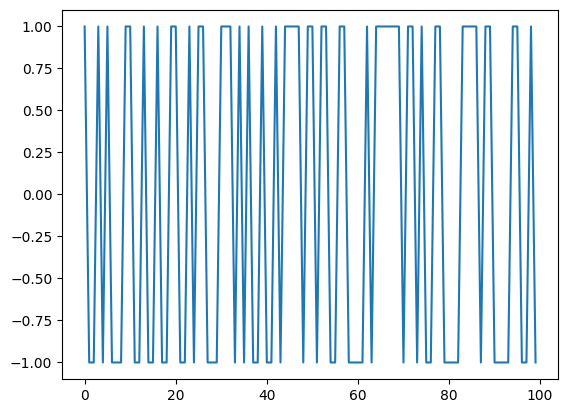

In [3]:
# generate random excitation signal
numsecs = 5
fundamental = 440
ks_wavtab_size = fs // fundamental #s integer division
wavetable = (2 * np.random.randint(0, 2, ks_wavtab_size) - 1).astype(np.float32)
wavetable_copy = wavetable.copy()
x = np.arange(100); plt.plot(x, wavetable[0:100]); plt.show

Above we see the random excitation signal. Now, we feed this signal through the Karplus-Strong algorithm and plot a close-up view of the waveform.

In [4]:
pluck = karplus_strong(wavetable, numsecs * fs)
Audio(pluck, rate = fs)

<function matplotlib.pyplot.show(close=None, block=None)>

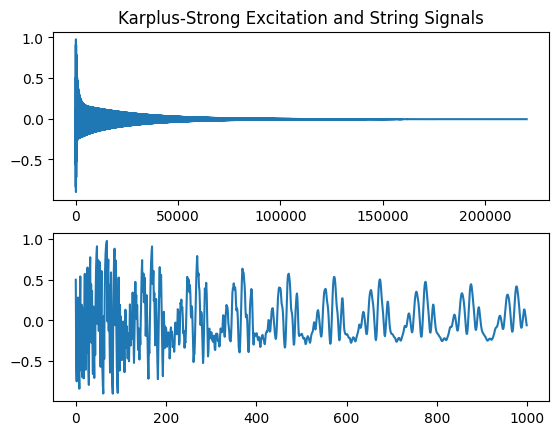

In [5]:
# plots of the resulting plucked-string waveform
plt.subplot(211) # why is plt like this -_-
plt.title("Karplus-Strong Excitation and String Signals")
plt.plot(pluck)
plt.subplot(212)
plotx = np.arange(1000); plt.plot(plotx, pluck[0:1000]); plt.show

## Valimaki et al. [2004]

### String Model
Below I reproduce the filter for the string model proposed in Valimaki et al. 2004. The input signal to the system is an excitation signal recorded from a real harpsichord's action.
The string filter is a feedback delay line much like the Karplus-Strong algorithm, including a one-pole and ripple filter to, respectively, strengthen highpass characteristics (since the feedback gain is a small negative number) and selecively suppress certain harmonics.

In [6]:
excite_sig_filename = "data/Cembalo-Excitation-Midtone.wav"
soundboard_impulse_filename = "data/Cembalo-Body-Model.wav"
writename = "Harpsi_Sample_A4.wav"
f_s, excite_sig_raw = wavfile.read(excite_sig_filename)
f_s, soundboard_impulse = wavfile.read(soundboard_impulse_filename)

excite_sig = excite_sig_raw.astype(np.float32) / float(np.iinfo(np.int16).max)
soundboard_impulse = excite_sig_raw.astype(np.float32) / float(np.iinfo(np.int16).max)

numsecs = 10
fundamental = 440 # Hz

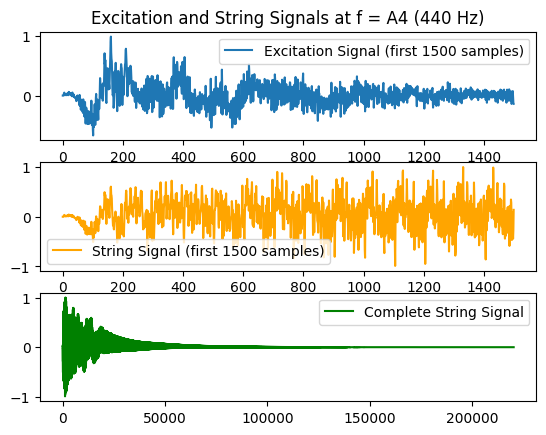

In [ ]:
_delay_line_len_float = f_s / fundamental # this is 'L' in the paper
_delay_line_len = int(np.floor(_delay_line_len_float))
_delay_line_frac = _delay_line_len_float - float(_delay_line_len) # this is *eta*, the fractional delay for the fractional delay filter
# NOTE: total delay line length is L = 1 + R + L_1 + F_z, where R = round(r_rate * L),
# where R and L_1 are integers, and L and F_z are real numbers, with 0 < F_z < 1.
# F_z is the delay caused by the fractional delay filter, which I am temporarily ignoring.
# ==> L_1 = L - round(r_rate * L) - 1; L_1 is the remainder of the delay line

##### BEGIN: STRING MODEL PIPELINE #####
# sample a signal, but define negative indices as 0
def read_sig(signal, index):
    if index < 0 or index >= len(signal):
        return 0
    else:
        return signal[index]

_loop_gain_g = 0.996 # should be slighly smaller than 1
_feedback_gain_a = -0.0296 # should be slighly less than 0
_scale_param_b = _loop_gain_g * (1 + _feedback_gain_a)

# this is 'r' in the paper. it must be that |r| < 1 − g. 
# controls deviation of overall loss filter from the one-pole filter
_ripple_depth_r = -0.0015 

# controls amount of delay dedicated to the ripple filter. 
# # this is 'r_rate' in the paper. do not confuse it with 'r'!
_r_rate = 0.0833 

_ripple_filt_delay_R = round(_r_rate * _delay_line_len)
_L_1 = _delay_line_len - _ripple_filt_delay_R - 1 # length of rest of delay line

# for low notes, larger negative values (like -0.7) seem to work best
# for high and mid notes, smaller negative values (like -0.25) seem to work best
# maybe the allpass filter isn't actually allpass-ing? 
_allpass_coeff_a_0 = -0.2 # where a_0 in [-1, 1]

_excite_coef = -0.7 # how much of the excitation we want to hear

def string_model(x_sig, len_secs, sample_rate):
    n_samples = len_secs * sample_rate
    y_harpsi_sig = np.zeros(n_samples) # output signal y
    # one_pole_buffer = np.zeros(n_samples)
    # ripple_buffer = np.zeros(n_samples)
    loss_buffer = np.zeros(n_samples)
    delay_buffer = np.zeros(n_samples)
    allpass_buffer = np.zeros(n_samples)

    sample_count = 0

    # BEGIN: filtering procedure
    while sample_count < n_samples:
        
        # loss filter
        loss_output = _scale_param_b * read_sig(y_harpsi_sig, sample_count - _ripple_filt_delay_R) - _feedback_gain_a * read_sig(loss_buffer, sample_count - 1) # one-pole
        loss_output += _scale_param_b * _r_rate * read_sig(y_harpsi_sig, sample_count) # ripple
        loss_buffer[sample_count] = loss_output

        # delay line part II
        delay_output = read_sig(loss_buffer, sample_count - _L_1)
        delay_buffer[sample_count] = delay_output
        # y_harpsi_sig[sample_count] = read_sig(x_sig, sample_count) + delay_output

        # linearly interpolated fractional delay filter
        # using this as-is dampens the sound enough that I don't find it worth including.
        # lagrange interpolation would give better results
        '''
        # fractional_delay_output = (1.0 - _delay_line_frac) * delay_output + _delay_line_frac * read_sig(delay_buffer, sample_count - 1)
        # y_harpsi_sig[sample_count] = read_sig(x_sig, sample_count) + fractional_delay_output
        '''

        # one-pole all-pass filter "A Simplified approach to modeling dispersion..." Duyne & Smith 1994
        # simulates acoustic dispersion due to string stiffness
        allpass_output = _allpass_coeff_a_0 * read_sig(delay_buffer, sample_count) + read_sig(delay_buffer, sample_count - 1) - _allpass_coeff_a_0 * read_sig(y_harpsi_sig, sample_count - 1)
        # allpass_buffer[sample_count] = allpass_output
        y_harpsi_sig[sample_count] = allpass_output + read_sig(x_sig, sample_count)

        sample_count += 1
    return np.array(y_harpsi_sig)

reverb_filt_spect = np.absolute(fft(soundboard_impulse))
string_signal = string_model(excite_sig, numsecs, f_s)
string_signal = string_signal / max(string_signal)

plot_start = 0; plot_range = 1500
plt.subplot(311) # why is plt like this -_-
plt.title("Excitation and String Signals at f = A4 (440 Hz)")
plotx = np.arange(plot_range - plot_start); plt.plot(plotx, excite_sig[plot_start:plot_range], label = "Excitation Signal (first 1500 samples)"); plt.show
plt.legend()
plt.subplot(312)
plotx = np.arange(plot_range - plot_start); plt.plot(plotx, string_signal[plot_start:plot_range], label = "String Signal (first 1500 samples)", color = "orange"); plt.show
plt.legend()
plt.subplot(313)
plotx = np.arange(len(string_signal) // 2); plt.plot(plotx, string_signal[plot_start:len(string_signal) // 2], label = "Complete String Signal", color = "green"); plt.show
plt.legend()

wavfile.write(writename, f_s, string_signal.astype(np.float32))
Audio(string_signal, rate = f_s)
##### END: STRING MODEL PIPELINE #####

### Soundbox Reverb

In [ ]:
_reverb_gain = 0.2 

reverb_signal = string_signal
_num_delay_lines = 1 # should be 8, start with 1 
_max_delay_len = 1999 # max delay line length in samples
_a_allpass_global = 0.5 # allpass filter coefficients, should be in [-1, 1]. In the paper, they were all set to 0.5

def soundbox_model(x_sig, len_secs, sample_rate):
    n_samples = len_secs * sample_rate
    y_harpsi_sig = np.zeros(n_samples) # output signal y

    sample_count = 0
    while sample_count < n_samples:
        sample_total = read_sig(y_harpsi_sig, sample_count)
        delay_lines_sum = 0
        for i in range(_num_delay_lines): # for each delay line
            this_delay_output = read_sig(y_harpsi_sig, sample_count - _max_delay_len) # sample outputted by this delay line
            # then put it thru a one pole loss filter 
            # then put it through a comb all pass filter

            delay_lines_sum += this_delay_output
        
        sample_count += 1

    return y_harpsi_sig